In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.base import BaseReweight
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling
from pflow.optimal_transport.recentering import LearnBest, IncrementalLearning
from joblib import Parallel, delayed


In [19]:
import pykalman
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### SSM defintion

In [3]:
class ProposalMethod(ProposalMethodBase):
    def __init__(self, bias, state_size):
        locs = torch.zeros(state_size, requires_grad=False) + bias
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=torch.eye(state_size))
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed =  0.5 * x + sample
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix):
        locs = torch.zeros(obs_matrix.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, 
                                                            scale_tril=torch.eye(observation_matrix.shape[0]))
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        
class NoResampling(BaseReweight):
    def apply(self, x, w, logw):
        return x, logw

In [4]:
_ = torch.random.manual_seed(0)

In [5]:
import math
import random
random.seed(42)

In [6]:
def autoregressive(transition_matrix, observation_matrix, seed=42):
    np.random.seed(seed)
    x = np.zeros(transition_matrix.shape[1])
    yield (observation_matrix @ x).squeeze() + np.random.randn(observation_matrix.shape[0])
    while True:
        x = (transition_matrix @ x).squeeze() + np.random.randn(x.shape[0])
        yield (observation_matrix @ x).squeeze() + np.random.randn(observation_matrix.shape[0])
    

In [7]:
# 1D

In [8]:
def ar_pf(values, 
          lamda, 
          observation_matrix,
          epsilon=0.5, 
          n=100, 
          seed=1234, 
          scaling=0.75, 
          reach=None, 
          min_neff=0.5, 
          resampling_method=None):
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_x = torch.zeros((n, observation_matrix.shape[1]))
    initial_x.requires_grad=False
    torch_observation = torch.tensor(observation_matrix.astype(np.float32))
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    
    likelihood_method = LikelihoodMethod(torch_observation)
    
    if resampling_method is None:
        if epsilon > 0:
            resampling_method = Transport(epsilon=epsilon, scaling=scaling, reach=reach)
        else:
            resampling_method = SystematicResampling()
    boot = BootstrapFilter(proposal_method=ProposalMethod(lamda, observation_matrix.shape[1]),
                           likelihood_method=likelihood_method, 
                           reweighting_method=resampling_method,
                           min_neff=min_neff)
    n_obs = 0
    for val in values:
        n_obs += 1
        obs = Observation(torch.tensor(val, requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik / n_obs, states, observations

In [11]:
linspace = np.linspace(-1, 1, 5)
n_experiments = 100
linspace

array([-1. , -0.5,  0. ,  0.5,  1. ])

In [12]:
T = 150
transition_matrix = np.array([[0.5]])
observation_matrix = np.array([[1.]])
observations_lists = []
for i in range(2):
    autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=i)
    ar = [next(autoregressive_gen) for _ in range(T)]
    observations_lists.append(np.asanyarray(ar[:]).astype(np.float32))


In [13]:
data = observations_lists[0]

In [14]:
N = 50

In [15]:
sys_ll = []
sys_grads = []
for value in tqdm.tqdm(linspace):
    lamda_tensor = torch.tensor(value, requires_grad=True)
    gradient_for_seed = []
    likelihood_for_seed = []
    for i in range(n_experiments):
        res = ar_pf(data, lamda_tensor, observation_matrix, 0., n=N, min_neff=0.5, seed=12345 + i)
        likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
        grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
        gradient_for_seed.append(grad.sum())
    sys_ll.append(likelihood_for_seed)
    sys_grads.append(gradient_for_seed)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:31<00:00, 18.41s/it]


In [16]:
reg_ll = {}
reg_grads = {}
for eps in [0.25, 0.5, 0.75]:
    reg_ll_list = []
    reg_grad_list = []
    for value in tqdm.tqdm(linspace):
        lamda_tensor = torch.tensor(value, requires_grad=True)
        gradient_for_seed = []
        likelihood_for_seed = []
        for i in range(n_experiments):
            res = ar_pf(data, lamda_tensor, observation_matrix, eps, scaling=0.33, n=N, min_neff=0.5, seed=12345 + i)
            likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
            grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
            gradient_for_seed.append(grad.sum())
        reg_ll_list.append(likelihood_for_seed)
        reg_grad_list.append(gradient_for_seed)
    reg_ll[eps] = reg_ll_list
    reg_grads[eps] = reg_grad_list

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:23<00:00, 53.71s/it]


In [17]:
learned_ll = {}
learned_grads = {}
eps = 0.5
for start_from_systematic, start_from_regularised in [[True, False], [False, True]]:
    learned_ll_list = []
    learned_grad_list = []
    for value in tqdm.tqdm(linspace):
        lamda_tensor = torch.tensor(value, requires_grad=True)
        gradient_for_seed = []
        likelihood_for_seed = []
        for i in range(n_experiments):
            resampling_method = LearnBest(0.1, {'scaling': 0.33}, learning_rate=1., optimizer_kwargs={}, 
                                          schedule_kwargs={'gamma': 0.75, 'step_size':1}, n_steps=5, 
                                          start_from_regularised=start_from_regularised, start_from_systematic=start_from_systematic, 
                                          jitter=0., 
                                          optim_class_name='SGD',
                                          scheduler_class_name='StepLR')
            res = ar_pf(data, lamda_tensor, observation_matrix,None, scaling=None, n=N, min_neff=0.5, seed=12345 + i, resampling_method=resampling_method)
            likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
            grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
            gradient_for_seed.append(grad.sum())
        learned_ll_list.append(likelihood_for_seed)
        learned_grad_list.append(gradient_for_seed)
    learned_ll[eps] = learned_ll_list
    learned_grads[eps] = learned_grad_list

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [31:01<00:00, 383.04s/it]


In [20]:
reg_ll = {k: pd.DataFrame(data=np.array(v).T, columns=linspace) for k, v in reg_ll.items()}
reg_grads = {k: pd.DataFrame(data=np.array(v).T, columns=linspace) for k, v in reg_grads.items()}

In [21]:
ll_for_kalman = []
grads_for_kalman = []

for value in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                           transition_covariance=[[1.]], 
                           transition_matrices=[[0.5]], 
                           transition_offsets=[value], 
                           initial_state_mean=[0.],
                           initial_state_covariance=[[0.]])
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                                   transition_covariance=[[1.]], 
                                   transition_matrices=[[0.5]], 
                                   transition_offsets=[value + 1e-4],
                                   initial_state_mean=[0.],
                                   initial_state_covariance=[[0.]])
    ll = kf.loglikelihood(data)
    ll_eps = kf_eps.loglikelihood(data)
    ll_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


In [103]:
sys_ll = np.array(sys_ll).T
sys_grads = np.array(sys_grads).T


In [113]:
sys_grads_df = pd.DataFrame(data=sys_grads, columns=linspace).describe().T
sys_grads_df['var'] = sys_grads_df['std']**2
sys_grads_df = sys_grads_df[['mean', 'var']]
sys_grads_df.columns = pd.MultiIndex.from_product([['systematic'], sys_grads_df.columns])

In [112]:
sys_ll_df = pd.DataFrame(data=sys_ll, columns=linspace).describe().T
sys_ll_df['var'] = sys_ll_df['std']**2
sys_ll_df = sys_ll_df[['mean', 'var']]
sys_ll_df.columns = pd.MultiIndex.from_product([['systematic'], sys_ll_df.columns])

In [130]:
grads_for_kalman_df = pd.DataFrame(index=linspace, data=grads_for_kalman, columns=['KF'])
grads_for_kalman_df.columns = pd.MultiIndex.from_tuples([('KF', 'mean')])
lls_for_kalman_df = pd.DataFrame(index=linspace, data=ll_for_kalman, columns=['KF'])
lls_for_kalman_df.columns = pd.MultiIndex.from_tuples([('KF', 'mean')])

In [144]:
reg_ll_df = pd.concat( reg_ll, axis=1 ).describe().T
reg_ll_df['var'] = reg_ll_df['std']**2
reg_ll_df = reg_ll_df[['mean', 'var' ]].unstack(0)
reg_ll_df = reg_ll_df.swaplevel(0, 1, axis=1).sort_index(axis=1)
reg_ll_df = reg_ll_df.rename({0.25: '$\epsilon = 0.25$', 0.5: '$\epsilon = 0.5$', 0.75: '$\epsilon = 0.75$'}, level=0, axis=1)

In [145]:
reg_grad_df = pd.concat( reg_grads, axis=1 ).describe().T
reg_grad_df['var'] = reg_grad_df['std']**2
reg_grad_df = reg_grad_df[['mean', 'var' ]].unstack(0)
reg_grad_df = reg_grad_df.swaplevel(0, 1, axis=1).sort_index(axis=1)
reg_grad_df = reg_grad_df.rename({0.25: '$\epsilon = 0.25$', 0.5: '$\epsilon = 0.5$', 0.75: '$\epsilon = 0.75$'}, level=0, axis=1)

In [148]:
likelihoods = pd.concat([ lls_for_kalman_df,  reg_ll_df, sys_ll_df ], axis = 1).round(1)
gradients_df = pd.concat([ grads_for_kalman_df,  reg_grad_df, sys_grads_df ], axis = 1).round(1)

In [152]:
for groupname, group in likelihoods.groupby(level=1, axis=1, squeeze=True):
    print(group.droplevel(1, axis=1).to_latex(escape=False))
    print('\n')

\begin{tabular}{lrrrrr}
\toprule
{} &     KF &  $\epsilon = 0.25$ &  $\epsilon = 0.5$ &  $\epsilon = 0.75$ &  systematic \\
\midrule
-1.0 & -338.5 &             -370.8 &            -378.8 &             -392.1 &      -361.0 \\
-0.5 & -290.4 &             -300.4 &            -302.7 &             -306.7 &      -297.6 \\
 0.0 & -272.1 &             -275.7 &            -275.9 &             -276.8 &      -275.4 \\
 0.5 & -283.4 &             -290.2 &            -292.2 &             -295.4 &      -288.9 \\
 1.0 & -324.4 &             -349.1 &            -355.2 &             -365.3 &      -340.8 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrr}
\toprule
{} &  $\epsilon = 0.25$ &  $\epsilon = 0.5$ &  $\epsilon = 0.75$ &  systematic \\
\midrule
-1.0 &               45.2 &              59.4 &               81.3 &        54.7 \\
-0.5 &               14.3 &              19.1 &               22.6 &        15.9 \\
 0.0 &                6.6 &               7.6 &                9.6 &         5.7 \

In [153]:
for groupname, group in gradients_df.groupby(level=1, axis=1, squeeze=True):
    print(group.droplevel(1, axis=1).to_latex(escape=False))
    print('\n')

\begin{tabular}{lrrrrr}
\toprule
{} &     KF &  $\epsilon = 0.25$ &  $\epsilon = 0.5$ &  $\epsilon = 0.75$ &  systematic \\
\midrule
-1.0 &  125.9 &              152.8 &             133.8 &              106.2 &       208.4 \\
-0.5 &   66.5 &               69.3 &              59.2 &               47.0 &       100.7 \\
 0.0 &    7.0 &                8.0 &               8.2 &                9.1 &         8.3 \\
 0.5 &  -52.4 &              -54.6 &             -45.0 &              -34.6 &       -81.8 \\
 1.0 & -111.8 &             -132.5 &            -117.5 &              -91.4 &      -184.4 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrr}
\toprule
{} &  $\epsilon = 0.25$ &  $\epsilon = 0.5$ &  $\epsilon = 0.75$ &  systematic \\
\midrule
-1.0 &              113.9 &             158.9 &              228.1 &       110.1 \\
-0.5 &              123.0 &             100.2 &              109.8 &        75.8 \\
 0.0 &               64.0 &              35.8 &               50.9 &        39.8 \

In [127]:
group.dr

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &     KF & \multicolumn{2}{l}{\$\textbackslash epsilon = 0.25\$} & \multicolumn{2}{l}{\$\textbackslash epsilon = 0.5\$} & \multicolumn{2}{l}{\$\textbackslash epsilon = 0.75\$} & \multicolumn{2}{l}{systematic} \\
{} &  value &              mean &  std &             mean &  std &              mean &  std &       mean &   var \\
\midrule
-1.0 & -338.5 &            -370.8 &  6.7 &           -378.8 &  7.7 &            -392.1 &  9.0 &     -361.0 &  54.7 \\
-0.5 & -290.4 &            -300.4 &  3.8 &           -302.7 &  4.4 &            -306.7 &  4.8 &     -297.6 &  15.9 \\
 0.0 & -272.1 &            -275.7 &  2.6 &           -275.9 &  2.7 &            -276.8 &  3.1 &     -275.4 &   5.7 \\
 0.5 & -283.4 &            -290.2 &  3.1 &           -292.2 &  3.5 &            -295.4 &  4.1 &     -288.9 &  12.4 \\
 1.0 & -324.4 &            -349.1 &  5.7 &           -355.2 &  6.6 &            -365.3 &  8.3 &     -340.8 &  38.8 \\
\bottomrule
\end{tabular}



In [33]:
pd.concat( reg_grads, axis=1 ).describe().T

count        mean        std         min         25%         50%  \
0.25 -1.0  100.0  152.774612  10.670311  119.577637  147.451229  153.659279   
     -0.5  100.0   69.325638  11.090935   34.477127   63.814249   70.444820   
      0.0  100.0    8.017167   7.997651  -11.809742    2.730824    8.083427   
      0.5  100.0  -54.622974  12.439397 -127.878685  -61.385360  -53.956594   
      1.0  100.0 -132.459198  10.366030 -166.808731 -139.563416 -131.563103   
0.50 -1.0  100.0  133.815353  12.606750   80.854347  127.619495  134.465233   
     -0.5  100.0   59.171925  10.010564   29.320345   52.971430   59.272335   
      0.0  100.0    8.192387   5.979207   -4.990794    4.399643    7.787692   
      0.5  100.0  -44.956730   8.404396  -61.862514  -50.261804  -46.774101   
      1.0  100.0 -117.459656   9.808718 -141.948700 -123.432941 -117.347721   
0.75 -1.0  100.0  106.201370  15.104319   61.458305   97.971352  107.529442   
     -0.5  100.0   47.034122  10.480418    9.775770   39.364689   48.114304   
      0.0  100.0    9.133266   7.133028   -3.857039    4.398526    8.815351   
      0.5  100.0  -34.622475   9.232634  -50.674904  -41.827640  -34.288731   
      1.0  100.0  -91.406258  11.516265 -118.498192  -98.297356  -92.549854   

                  75%         max  
0.25 -1.0  159.119572  177.551025  
     -0.5   75.802649   90.910156  
      0.0   12.922085   26.273151  
      0.5  -46.312810  -28.792048  
      1.0 -126.122681 -109.499962  
0.50 -1.0  141.501293  171.757095  
     -0.5   66.572065   82.316216  
      0.0   11.591913   23.789997  
      0.5  -39.757578  -23.051458  
      1.0 -110.957050  -76.633972  
0.75 -1.0  116.789873  137.404892  
     -0.5   53.977877   70.906433  
      0.0   14.266321   28.326651  
      0.5  -28.715947  -12.024765  
      1.0  -85.135262  -57.452908

In [30]:
pd.concat( reg_ll, axis=1 ).describe().T

count        mean       std         min         25%         50%  \
0.25 -1.0  100.0 -370.760167  6.723331 -389.632308 -375.074297 -370.501220   
     -0.5  100.0 -300.399018  3.776638 -310.342491 -302.565140 -300.346595   
      0.0  100.0 -275.731867  2.575797 -282.075781 -277.621154 -275.824580   
      0.5  100.0 -290.233106  3.104734 -297.340178 -292.234379 -290.456718   
      1.0  100.0 -349.128548  5.654169 -368.020570 -352.412125 -349.381953   
0.50 -1.0  100.0 -378.760074  7.707408 -399.215305 -384.022397 -378.629994   
     -0.5  100.0 -302.719582  4.372832 -314.951241 -305.149654 -302.041662   
      0.0  100.0 -275.872178  2.749350 -282.333094 -277.610564 -275.965914   
      0.5  100.0 -292.199805  3.524939 -302.731133 -294.618823 -292.243257   
      1.0  100.0 -355.167306  6.581486 -375.188935 -359.224391 -355.260068   
0.75 -1.0  100.0 -392.073177  9.014621 -417.370141 -398.570707 -392.020512   
     -0.5  100.0 -306.725301  4.758660 -319.455957 -309.536263 -306.491071   
      0.0  100.0 -276.756900  3.103235 -283.441222 -278.792162 -276.945555   
      0.5  100.0 -295.432899  4.078106 -307.460332 -297.844644 -295.729065   
      1.0  100.0 -365.277017  8.307225 -388.259161 -369.762683 -365.215069   

                  75%         max  
0.25 -1.0 -366.511542 -354.039538  
     -0.5 -297.754003 -290.656489  
      0.0 -274.045336 -267.941773  
      0.5 -288.373022 -282.034332  
      1.0 -345.124733 -337.403226  
0.50 -1.0 -373.978212 -357.150435  
     -0.5 -299.836604 -293.268800  
      0.0 -274.209031 -268.646389  
      0.5 -289.684573 -283.237213  
      1.0 -350.760010 -340.508580  
0.75 -1.0 -385.996243 -368.083513  
     -0.5 -303.716844 -294.703925  
      0.0 -274.661855 -267.550206  
      0.5 -292.551541 -284.532166  
      1.0 -359.262791 -347.408295

In [31]:
pd.Series(index=linspace, data=ll_for_kalman)

-1.0   -338.531065
-0.5   -290.449429
 0.0   -272.071858
 0.5   -283.398354
 1.0   -324.428916
dtype: float64

In [33]:
reg_grads[0.25].describe().T
# Grads for regularised transport

,count,mean,std,min,25%,50%,75%,max
0.25,100.0,-21.003189,9.276321,-44.329620,-27.589764,-20.358386,-14.358385,-2.192927
0.50,100.0,-54.622974,12.439397,-127.878685,-61.385360,-53.956594,-46.312810,-28.792048
0.75,100.0,-90.912178,14.023564,-129.487564,-99.749702,-90.362057,-84.904913,-12.024521
1.00,100.0,-132.459198,10.366030,-166.808731,-139.563416,-131.563103,-126.122681,-109.499962
1.25,100.0,-177.789062,13.839606,-213.851013,-184.664078,-177.529045,-171.848469,-101.211128
1.50,100.0,-229.519318,12.831076,-254.511902,-239.412476,-229.357483,-221.756405,-187.637192


In [34]:
pd.DataFrame(data=sys_grads, columns=linspace).describe().T
# Grads for systematic resampling

,count,mean,std,min,25%,50%,75%,max
0.25,100.0,-37.427677,6.684563,-49.487583,-42.012128,-37.779648,-33.117282,-18.518425
0.50,100.0,-81.766922,7.957031,-104.882645,-86.477066,-82.464214,-77.096727,-58.735275
0.75,100.0,-128.692398,9.238801,-146.678925,-135.275475,-128.243809,-122.243851,-105.014893
1.00,100.0,-184.365234,9.607133,-210.251495,-190.231117,-185.446007,-176.610081,-165.332108
1.25,100.0,-243.686111,11.827558,-276.510193,-251.834301,-244.026268,-234.789387,-215.729065
1.50,100.0,-316.739197,14.197841,-352.251495,-324.724091,-315.564301,-308.558403,-285.973328


In [35]:
gradients_for_learnt = {}
ll_for_learnt = {}
for start_from_systematic, start_from_regularised in [[True, False], [False, True]]:
    gradients = []
    likelihoods = []
    for data in tqdm.tqdm(observations_lists):
        gradients_data = []
        likelihoods_data = []
        for value in linspace:
            lamda_tensor = torch.tensor(value, requires_grad=True)
            gradient_for_seed = []
            likelihood_for_seed = []
            for i in range(n_experiments):
                learnt_resampling_method = LearnBest(0.1, {'scaling': 0.5}, learning_rate=1., optimizer_kwargs={}, 
                                                     schedule_kwargs={'gamma': 0.9, 'step_size':1}, n_steps=5, 
                                                     start_from_regularised=start_from_regularised, start_from_systematic=start_from_regularised, 
                                                     jitter=0., 
                                                     optim_class_name='SGD',
                                                     scheduler_class_name='StepLR')
                res = ar_pf(data, lamda_tensor, observation_matrix, None, scaling=None, n=15, min_neff=0.5, seed=12345 + i, resampling_method=learnt_resampling_method)
                likelihood_for_seed.append(-res[0].detach().cpu().numpy().sum()*T)
                grad = torch.autograd.grad(-res[0] * T, lamda_tensor)[0].detach().cpu().numpy()
                gradient_for_seed.append(grad.sum())
            gradients_data.append(gradient_for_seed)
            likelihoods_data.append(likelihood_for_seed)
        likelihoods.append(likelihoods_data)
        gradients.append(gradients_data)
    gradients_for_learnt[(start_from_systematic, start_from_regularised)] = gradients
    ll_for_learnt[(start_from_systematic, start_from_regularised)] = likelihoods

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:19:17<00:00, 2394.51s/it]


In [ ]:
ll_for_kalman = []
grads_for_kalman = []

for data in tqdm.tqdm(observations_lists):
    gradients_data = []
    likelihoods_data = []
    for value in linspace:
        kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                               transition_covariance=[[1.]], 
                               transition_matrices=[[0.5]], 
                               transition_offsets=[value], 
                               initial_state_mean=[0.],
                               initial_state_covariance=[[0.]])
        kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                                       transition_covariance=[[1.]], 
                                       transition_matrices=[[0.5]], 
                                       transition_offsets=[value + 1e-4],
                                       initial_state_mean=[0.],
                                       initial_state_covariance=[[0.]])
        ll = kf.loglikelihood(data)
        ll_eps = kf_eps.loglikelihood(data)
        likelihoods_data.append(ll)
        gradients_data.append(1e4*(ll_eps-ll))
    ll_for_kalman.append(likelihoods_data)    
    grads_for_kalman.append(gradients_data)

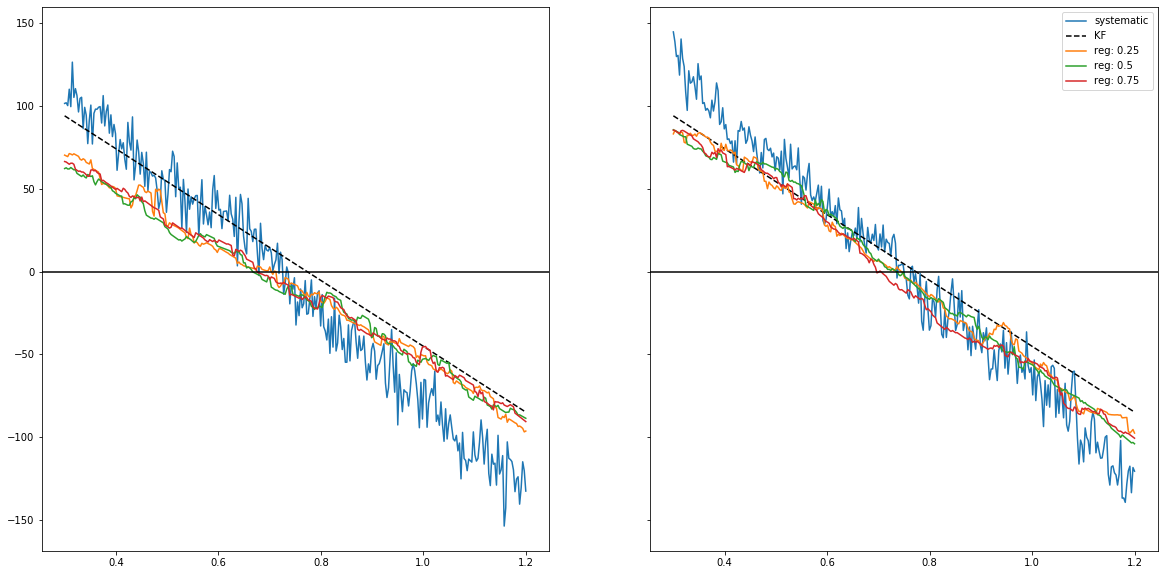

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    systematic_grad = gradients_for_systematic[15][ i ]
    ax.plot(linspace, np.mean(systematic_grad, 1), label = 'systematic')    
    ax.plot(linspace, grads_for_kalman[1], label = 'KF', color = 'k', linestyle='--')    
    for eps, transport_gradients in gradients_for_transport.items():
        ax.plot(linspace, np.mean(transport_gradients[i], 1), label = 'reg: {}'.format(eps))    
#     for (start_from_systematic, start_from_regularised), learnt_gradients in gradients_for_learnt.items():
#         label = 'from systematic' if start_from_systematic else 'from regularised'
#         ax.plot(linspace, np.mean(learnt_gradients[i], 1), label = label)

    ax.axhline(0, linestyle='-', color='k')
_ = ax.legend()

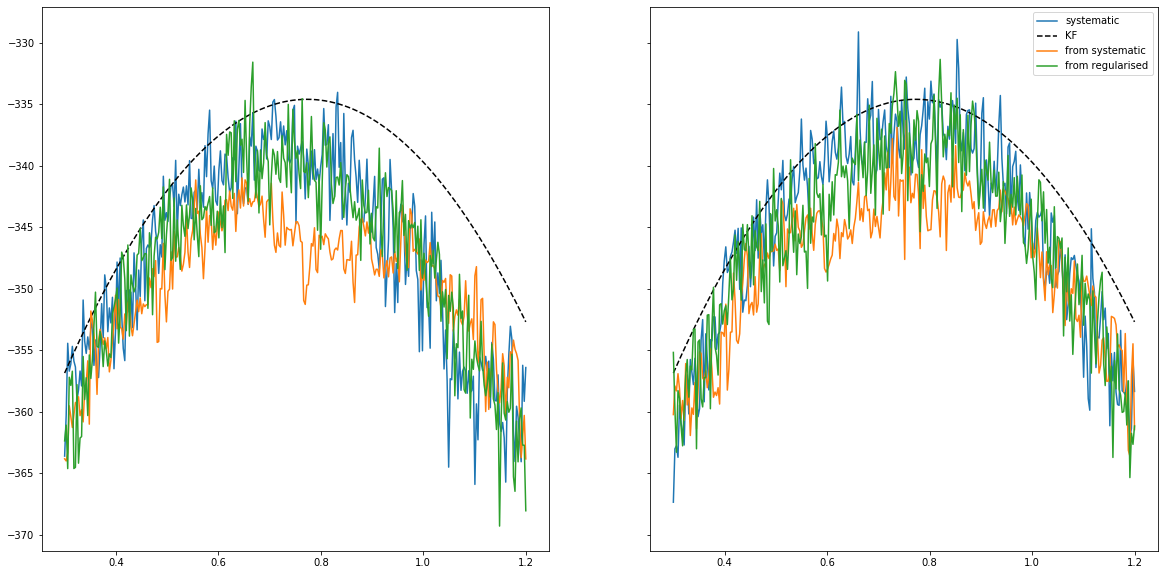

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    systematic_ll = ll_for_systematic[15][ i ]
    ax.plot(linspace, np.mean(systematic_ll, 1), label = 'systematic')    
    ax.plot(linspace, ll_for_kalman[1], label = 'KF', color = 'k', linestyle='--')    

#     for eps, ll_transport in ll_for_transport.items():
#         ax.plot(linspace, np.mean(ll_transport[i], 1), label = 'reg: {}'.format(eps), linewidth  = 1)    
    for (start_from_systematic, start_from_regularised), learnt_ll in ll_for_learnt.items():
        label = 'from systematic' if start_from_systematic else 'from regularised'
        ax.plot(linspace, np.mean(learnt_ll[i], 1), label = label)

_ = ax.legend()

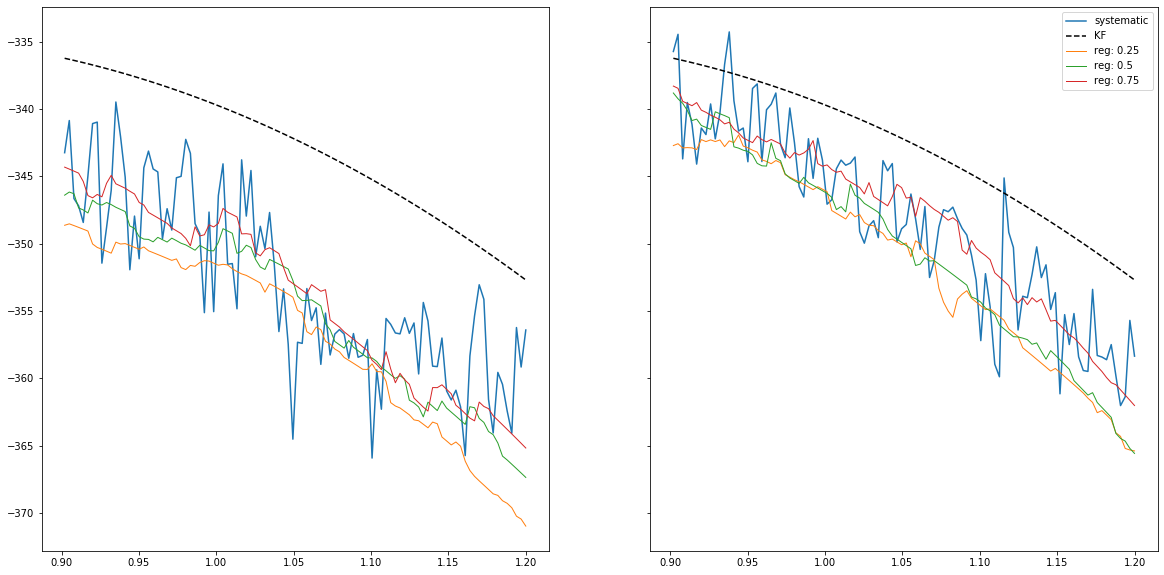

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
sub_slice = slice(200, 300)
for i, ax in enumerate(axes.flatten()):
    systematic_ll = ll_for_systematic[15][i]
    ax.plot(linspace[sub_slice], np.mean(systematic_ll, 1)[sub_slice], label = 'systematic')    
    ax.plot(linspace[sub_slice], ll_for_kalman[1][sub_slice], label = 'KF', color = 'k', linestyle='--')    

    for eps, ll_transport in ll_for_transport.items():
        ax.plot(linspace[sub_slice], np.mean(ll_transport[i], 1)[sub_slice], label = 'reg: {}'.format(eps), linewidth  = 1)    

_ = ax.legend()

### Let's learn

In [ ]:
n_iter = 20
lr = 1.
lamda_tensor = torch.tensor(0., requires_grad=True)
lambda_values_sys = [0.]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=5)

for _ in tqdm.trange(n_iter):
    data = observations_lists[0]
    
    temp_res = ar_pf(data, lamda_tensor, observation_matrix, 0., n=10, min_neff=0.5)
    grad = torch.autograd.grad(temp_res[0], lamda_tensor)
    lamda_tensor.data -= lr * grad[0]
    lambda_values_sys.append(lamda_tensor.detach().cpu().numpy().sum())


In [ ]:
n_iter = 20
lr = 1.
lamda_tensor = torch.tensor(0., requires_grad=True)
lambda_values_transport = [0.]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=5)

for _ in tqdm.trange(n_iter):
    ar = [next(autoregressive_gen) for _ in range(200)]
    data = observations_lists[0]
    
    temp_res = ar_pf(data, lamda_tensor, observation_matrix, 0.5, scaling=0.5, n=10, min_neff=0.5, seed=666)
    grad = torch.autograd.grad(temp_res[0], lamda_tensor)
    lamda_tensor.data -= lr * grad[0]
    lambda_values_transport.append(lamda_tensor.detach().cpu().numpy().sum())


In [ ]:
plt.plot(lambda_values_sys)

In [ ]:
plt.plot(lambda_values_transport)

In [ ]:
n_iter = 20
lr = 0.01
lamda_val = 0.
lamda_val_list = [lamda_val]
autoregressive_gen = autoregressive(transition_matrix, observation_matrix, seed=1)

for _ in tqdm.trange(n_iter):
    ar = [next(autoregressive_gen) for _ in range(200)]
    data = observations_lists[0]
    
    kf = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                               transition_covariance=[[1.]], 
                               transition_matrices=[[0.5]], 
                               transition_offsets=[lamda_val], 
                               initial_state_mean=[0.],
                               initial_state_covariance=[[0.]])
    
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[1.]], 
                                  transition_covariance=[[1.]], 
                                   transition_matrices=[[0.5]], 
                                   transition_offsets=[lamda_val + 1e-6],
                                   initial_state_mean=[0.],
                                   initial_state_covariance=[[0.]])
    
    ll = -kf.loglikelihood(data)
    ll_eps = -kf_eps.loglikelihood(data)
    grad = (ll_eps - ll) * 1e6
    lamda_val -= lr * grad
    lamda_val_list.append(lamda_val)



In [ ]:
plt.plot(lamda_val_list)

In [ ]:
plt.plot(phi_tensors_ot, label = 'learn OT')
plt.plot(phi_tensors_sys, label = 'learn Sys')
plt.plot(phi_tensors_kf, label = 'learn KF')
plt.legend()

In [ ]:
alpha = 0.42
d = 10
transition_matrix = np.asarray([[alpha ** (abs(i-j) + 1) for j in range(1, d+1)] for i in range(1, d+1)])

In [ ]:
n_obs = 1
sparse_observation = np.eye(n_obs, d, dtype=float)

In [ ]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, np.sqrt(variance))

In [ ]:
def plot_pf_component(pf_res, linspace, component, ax, label, show=None):
    pf_state, pf_weight = zip(*[(l.x.detach().cpu().numpy(),  l.w.detach().cpu().numpy()) for l in pf_res[1]])
    pf_weight = np.stack(pf_weight, axis=0)
    pf_state = np.stack(pf_state, axis=0)

    pf_mean, pf_std = weighted_avg_and_std(pf_state[:, :, component].T,  pf_weight.T)
    ax.plot(linspace[: show], pf_mean[: show], label = label)
    ax.fill_between(linspace[: show], 
                    pf_mean[: show] - 2 * pf_std[: show],
                    pf_mean[: show] + 2 * pf_std[: show], alpha = 0.3)
    

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

show = 100
linspace = np.arange(0, T)

axes[0, 0].plot(linspace[: show], ar_kf[0][:, 0].squeeze()[: show], label='Kalman Filter')
axes[0, 0].fill_between(linspace[: show], 
                     ar_kf[0][:, 0].squeeze()[: show] - 2*np.sqrt(ar_kf[1][:, 0, 0])[: show],
                     ar_kf[0][:, 0].squeeze()[: show] + 2*np.sqrt(ar_kf[1][:, 0, 0])[: show], alpha = 0.3)


plot_pf_component(ar_10, linspace, 0, axes[1, 0], 'particle filter, eps = 0.1', show)
plot_pf_component(ar_100, linspace, 0, axes[1, 1], 'particle filter, eps = 1.00', show)
plot_pf_component(ar_systematic, linspace, 0, axes[0, 1], 'particle filter, systematic', show)


for ax in axes.flatten():
    ax.legend(loc='upper right')

# axes[0].set_title('AR(1)')

# fig.savefig('AR_PF_optimalTransport.png')

In [ ]:
linspace = np.linspace(0.25, 0.75, 250)
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1.]

In [ ]:
results_for_smoothness_ot_dict = {}
results_for_smoothness_ot_grad_dict = {}
for eps in epsilons:
    results_for_smoothness_ot_dict[eps] = []
    results_for_smoothness_ot_grad_dict[eps] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, eps, n=100, scaling=0.9, min_neff=0.5, reach=None)
#         temp_res = run_pf(flat, log_sigma_val, dt_tensor, eps, n=100, scaling=0.9, min_neff=0.5, reach=5.)
        results_for_smoothness_ot_grad_dict[eps].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_ot_dict[eps].append(temp_res[0].detach().cpu().numpy())
    


In [ ]:
results_for_smoothness_systematic_dict = {}
results_for_smoothness_systematic_grad_dict = {}
for n in [100]:
    results_for_smoothness_systematic_dict[n] = []
    results_for_smoothness_systematic_grad_dict[n] = []
    for val in tqdm.tqdm(linspace):
        phi_tensor = torch.tensor(val, requires_grad=True)
        temp_res = ar_pf(observations, phi_tensor, log_noise, log_error, 0., n=100, min_neff=0.5)
        results_for_smoothness_systematic_grad_dict[n].append(torch.autograd.grad(temp_res[0], phi_tensor)[0].detach().cpu().numpy())
        results_for_smoothness_systematic_dict[n].append(temp_res[0].detach().cpu().numpy())


In [ ]:
# results_for_learnt_ot_dict = {}
# eps = 0.1
# adam_kwargs = {'lr': 0.5}
# methods = {#'incremental': IncrementalLearning(eps, {'scaling': 0.5}, adam_kwargs, 4, 5),
#            'one-shot': LearnBest(eps, {'scaling': 0.75}, adam_kwargs, 10)}
# for name, method in methods.items():
#     results_for_learnt_ot_dict[name] = [~]
#     for val in tqdm.tqdm(linspace):
#         log_sigma_tensor = torch.tensor(val, requires_grad=False)
#         temp_res = run_pf(flat, log_sigma_tensor, dt_tensor, eps, n=250, reweighting_method=method)
#         results_for_learnt_ot_dict[name].append(temp_res[0].detach().cpu().numpy())


In [ ]:
results_for_kalman = []
grads_for_kalman = []
for val in tqdm.tqdm(linspace):
    kf = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                               transition_covariance=[[0.01]], 
                               transition_matrices=[[val]], 
                               initial_state_mean=[0.])
    kf_eps = pykalman.KalmanFilter(observation_covariance=[[0.01]], 
                                   transition_covariance=[[0.01]], 
                                   transition_matrices=[[val + 1e-4]], 
                                   initial_state_mean=[0.])
    ll = -kf.loglikelihood(observations)/len(observations)
    ll_eps = -kf_eps.loglikelihood(observations)/len(observations)
    results_for_kalman.append(ll)
    grads_for_kalman.append(1e4*(ll_eps-ll))

In [ ]:
def plot_gradient(linspace, values, gradients, k, ax, line):
    x = np.take(linspace, k)
    y = np.take(values, k)
    v = np.take(gradients, k)
    u = [1]*len(k)
    ax.quiver(x, y, u, v, scale=20, zorder=3, color=l.get_color(),
          width=0.007, headwidth=3., headlength=4.)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4), sharey=False, sharex=False)
fig.suptitle('Likelihood function comparison', y = 1.01)

for eps, lst in results_for_smoothness_ot_dict.items():
    if eps >= 0.25:
        arr = np.asanyarray(lst)
        ax.plot(linspace, arr - arr.min(), label=f'Biased OT: eps={eps}')
arr_sys = np.asanyarray(results_for_smoothness_systematic_dict[100])
ax.plot(linspace, arr_sys - arr_sys.min(), label=f'Systematic resampling', alpha=0.5)

arr_kf = np.asanyarray(results_for_kalman)
ax.plot(linspace, arr_kf - arr_kf.min(), label = 'Kalman filter', linestyle = '--')

# zoom = slice(0, 250)
# grads_locs =  [25, 100, 175]
# for eps, lst in results_for_smoothness_ot_dict.items():
#     l, = axes[1].plot(linspace[zoom], lst[zoom], label=f'Biased OT: eps={eps}')
#     plot_gradient(linspace, lst, results_for_smoothness_ot_grad_dict[eps], grads_locs, axes[1], l)

# l, = axes[1].plot(linspace[zoom], results_for_smoothness_systematic_dict[100][zoom], label=f'Systematic resampling', alpha=0.5)
# plot_gradient(linspace, results_for_smoothness_systematic_dict[100], results_for_smoothness_systematic_grad_dict[100], grads_locs, axes[1], l)

# axes[1].plot(linspace[zoom], results_for_kalman[zoom], label = 'Kalman filter', linestyle = '--')

# for ax in axes.flatten():
ax.set_ylabel('$\\frac{-loglik}{n_{samples}}$', rotation=0, y=1, fontsize=15)
ax.set_xlabel('$\phi$', rotation=0, y=1, fontsize=15)
    
ax.legend()
    
fig.savefig('ar_likelihood.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Likelihood function gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.stack(grads), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.stack(results_for_smoothness_systematic_grad_dict[100]), label='Systematic Resampling')
ax.plot(linspace, np.stack(grads_for_kalman), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4), sharey=False, sharex=True)
fig.suptitle('Antiderivative (cumsum) gradient comparison', y = 1.01)
for eps, grads in results_for_smoothness_ot_grad_dict.items():
    if eps >= 0.25:
        ax.plot(linspace, np.cumsum(np.stack(grads)), label = f'Biased OT: eps={eps}')
    
ax.plot(linspace, np.cumsum(np.stack(results_for_smoothness_systematic_grad_dict[100])), label='Systematic Resampling')
ax.plot(linspace, np.cumsum(np.stack(grads_for_kalman)), label='KF', linestyle='--')

ax.legend()
fig.savefig('ar_likelihoodGradient.png')